In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm, DivergingNorm
import matplotlib.colors as colors
import qcodes as qc
import qcodes.instrument_drivers.nplab_drivers as npd
from scipy.optimize import curve_fit
from scipy.interpolate import interp2d, interp1d
from os import path
import colorcet as cc   # install quickly with "conda install colorcet"
from scipy.interpolate import RectBivariateSpline
from matplotlib import ticker
from scipy.ndimage import gaussian_filter
import matplotlib as mpl
from lmfit import Model

In [3]:
cd ..

/Users/robertpolski/Documents/NPGroupResearch/Measurements/Triton/qcodes_data


In [4]:
qc.DataSet.default_io.base_location = path.abspath('.')
figfile = path.abspath('.') + '/Figures/200129_W3_W5Analysis/'

In [5]:
font = {
                'family': 'Arial',
                'size': 12,
                'serif': 'Times',
                'sans-serif': 'Arial'
            }

plt.rc('font', **font)

In [6]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['figure.dpi'] = 300
%config InlineBackend.figure_format = 'svg'

In [7]:
# %matplotlib widget

# W3 device analysis

Double-sided WSe2 device

## W3 Contacts 47-48 Landau Fan

In [7]:
# despite the data names, these contacts are on W3

fan1data = qc.load_data('data/2020-02-13/#003_W5_865_47-48_830_20-48_baseT_1nA_B-Vgsweep_11-01-44')
fan2data = qc.load_data('data/2020-02-15/#001_W5_865_47-48_830_20-48_baseT_1nA_B-Vgsweep_10-40-22')


# electrodes 47-48
fields4748 = np.concatenate((fan1data.triton_field_set_stable_set[:126], fan2data.triton_field_set_stable_set[:]))
gates4748 = fan1data.srframe_volt_p1_set[0, :]
Rxx4748 = np.vstack((npd.Rxxfromdata(fan1data, 1e-9)[:126, :], npd.Rxxfromdata(fan2data, 1e-9)))
Rxx4748func = RectBivariateSpline(gates4748, fields4748[::-1], np.flip(Rxx4748, axis=0).T, kx=1, ky=1)

fields2048 = np.concatenate((fan1data.triton_field_set_stable_set[:126], fan2data.triton_field_set_stable_set[:]))
gates2048 = fan1data.srframe_volt_p1_set[0, :]
Rxx2048 = np.vstack((npd.Rxxfromdata(fan1data, 1e-9, 'lockin830')[:126, :], npd.Rxxfromdata(fan2data, 1e-9, 'lockin830')))
# Rxx4748func = RectBivariateSpline(gatesw5, fieldsw5[::-1], np.flip(Rxxw5, axis=0).T, kx=1, ky=1)

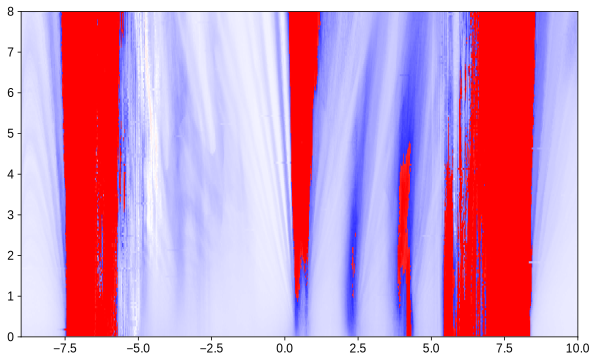

In [8]:
plt.figure(figsize=(10, 6))
plt.pcolormesh(gates2048, fields2048, Rxx2048, cmap='bwr', vmin=-60e3, vmax=60e3, rasterized=True)

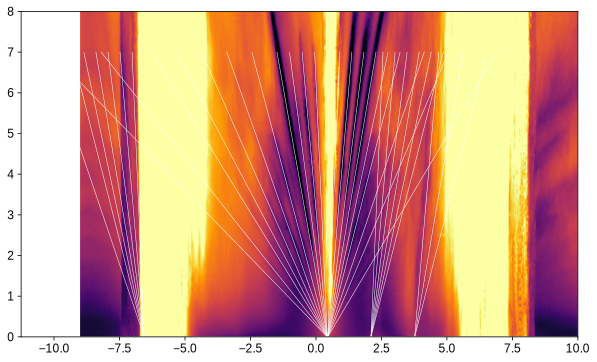

In [9]:
x = np.linspace(-9, 10, 1501)
y = np.linspace(0, 8, 801)
Rxx4748_int = gaussian_filter(Rxx4748func(x, y).T, (1, 1))

plt.figure(figsize=(10, 6))
plt.pcolormesh(x,y , Rxx4748_int, cmap='inferno', rasterized=True, norm=SymLogNorm(1000, vmin=0, vmax=1e5))
# plt.axis((-9, -5.8, 0, 8))



sl0 = 14.6  #from the 0.79 degree data CNP
V0 = 0.43
Bl = 7
Bs = 0
b = -V0*sl0
for i in [-22, -18, -14, -12, -10, -8, -6, -4, -3, -2, -1]:
    x = np.array([(Bs*i - b)/sl0, (Bl*i - b)/sl0])
    plt.plot(x, (x*sl0 + b)/i, color='white', lw=0.5)


#positive side
sl0 = 15.2
V0 = 0.45
b = -V0*sl0
for i in [1, 2, 3, 4, 5, 6, 8, 10, 14]:
    x = np.array([(Bs*i - b)/sl0, (Bl*i - b)/sl0])
    plt.plot(x, (x*sl0 + b)/i, color='white', lw=0.5)
    
# negative full filling
sl0 = 15.2  #from the 0.79 degree data CNP
V0 = -6.56
b = -V0*sl0
for i in [-1, -2,-3,  -4, -5, -6, -8]:
    x = np.array([(Bs*i - b)/sl0, (Bl*i - b)/sl0])
    plt.plot(x, (x*sl0 + b)/i, color='white', lw=0.5)
    
# positive quarter filling
sl0 = 15.2
V0 = 2.1
b = -V0*sl0
for i in [1, 2, 3, 4, 5, 6]:
    x = np.array([(Bs*i - b)/sl0, (Bl*i - b)/sl0])
    plt.plot(x, (x*sl0 + b)/i, color='white', lw=0.5)
    
# positive half filling
sl0 = 15.2
V0 = 3.77
b = -V0*sl0
for i in [2, 4, 6]:
    x = np.array([(Bs*i - b)/sl0, (Bl*i - b)/sl0])
    plt.plot(x, (x*sl0 + b)/i, color='white', lw=0.5)

In [10]:
# assume 15.2 is the actual slope, and use the V0 from the positive side of the CNP since that slope was 15.2.
sl = 15.2
V0 = 0.45
C = sl*1.602e-19**2/6.626e-34
dBN = 3*8.85e-12/C
print('effective capacitance: {:.4e}'.format(C))
print('effective hBN thickness: {:.1f} nm'.format(dBN*10**9))

effective capacitance: 5.8873e-04
effective hBN thickness: 45.1 nm


In [11]:
# first try with the negative full filling fan... perhaps not right...
V0fullh = -6.56
Vgatefull = V0-V0fullh
print('Full filling voltage difference: {}'.format(Vgatefull))
nfull = (Vgatefull)*C/1.602e-19/10**4
print(nfull/10**12) #10**12 cm^-2
a = 0.246e-9

theta = np.sqrt(np.sqrt(3)*nfull*10**4*a**2/8)*180/np.pi
print('theta: ', theta)

Full filling voltage difference: 7.01
2.5761591306972536
theta:  1.0526388697864308


In [12]:
# now try with the half filling intercept
Vgatefull = (3.77 - 0.45)*2
print('Full filling voltage difference: {}'.format(Vgatefull))
nfull = (Vgatefull)*C/1.602e-19/10**4
print(nfull/10**12) #10**12 cm^-2
a = 0.246e-9

theta = np.sqrt(np.sqrt(3)*nfull*10**4*a**2/8)*180/np.pi
print('theta: ', theta)

Full filling voltage difference: 6.64
2.4401849683066708
theta:  1.0244822385867682


## Contacts 48-24

In [13]:
dfan4824 = qc.load_data('data/2020-02-11/#002_W5_865_48-24_830_21-24_baseT_1nA_B-Vgsweep_09-37-41')

g4824 = dfan4824.srframe_volt_p1_set[0, 23:]
B4824 = dfan4824.triton_field_set_stable_set[:]
Rxx4824 = npd.Rxxfromdata(dfan4824, 2e-9)[:, 23:]

In [14]:
indices = [i not in (21, 22) for i in range(len(B4824))]  # get rid of the bump near 1T
R4824func = RectBivariateSpline(g4824, B4824[indices], Rxx4824[indices, :].T, kx=1, ky=1)

(-8.5, 10)

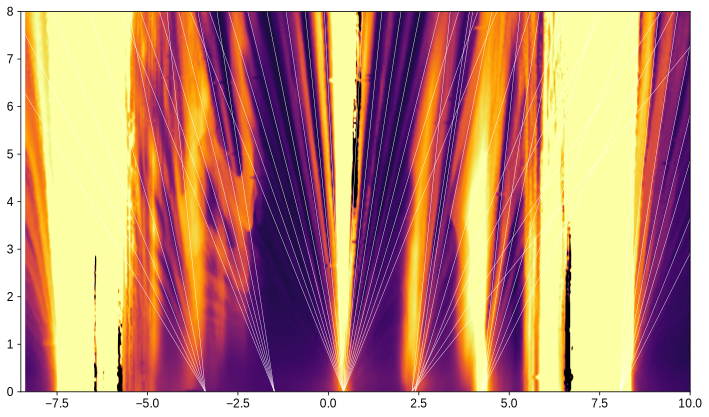

In [15]:
g4824int = np.linspace(-8.375, 10, 1500)
y4824int = np.linspace(0, 8, 600)
Rxx4824int = gaussian_filter(R4824func(g4824int, y4824int).T, (1.2, 1.2))

fig, ax = plt.subplots(figsize=(12, 7))
norm = colors.SymLogNorm(2000, vmin=-500, vmax=1e4)
p1 = ax.pcolormesh(g4824int, y4824int, Rxx4824int, cmap='inferno', norm=norm, rasterized=True)

Bl = 8
Bs = 0
V0 = 0.42
sl = 15.1
b = -V0*sl
LW = 0.4

# CNP
for i in [-8, -7, -5, -6, -4, -3, -2, -1, 1, 2, 3, 4, 5, 6, 7, 8]:
    x = np.linspace((Bs*i - b)/sl, (Bl*i - b)/sl, 10)
    ax.plot(x, (x*sl + b)/i, color='white', lw=LW)
    
#+half filling
Vhp = 4.24
Vgatefull = (Vhp - V0)*2
b = -Vhp*sl
for i in [2, 3, 4, 6, 8, 10]:
    x = np.linspace((Bs*i - b)/sl, (Bl*i - b)/sl, 10)
    ax.plot(x, (x*sl + b)/i, color='white', lw=LW)
    
#-half filling
Vnhp = V0 - Vgatefull/2
b = -Vnhp*sl
for i in [-2, -4, -6, -8, -10, -12]:
    x = np.linspace((Bs*i - b)/sl, (Bl*i - b)/sl, 10)
    ax.plot(x, (x*sl + b)/i, color='white', lw=LW)
    
#+quarter filling
Vqp = V0 + Vgatefull/4 +0.07
b = -Vqp*sl
for i in [3, 4, 6, 8]:
    x = np.linspace((Bs*i - b)/sl, (Bl*i - b)/sl, 10)
    ax.plot(x, (x*sl + b)/i, color='white', lw=LW)
    
Vqp = V0 + Vgatefull/4 - 0.02
b = -Vqp*sl
for i in [2, 3, 10, 13, 16]:
    x = np.linspace((Bs*i - b)/sl, (Bl*i - b)/sl, 10)
    ax.plot(x, (x*sl + b)/i, color='white', lw=LW)
    
#-quarter filling
Vqp = V0 - Vgatefull/4
b = -Vqp*sl
for i in [-3, -4, -5, -6, -7, -8]:
    x = np.linspace((Bs*i - b)/sl, (Bl*i - b)/sl, 10)
    ax.plot(x, (x*sl + b)/i, color='white', lw=LW)
    
#+full filling
Vgatefull = (Vhp - V0)*2
Vfp = V0 + Vgatefull + 0.01
b = -Vfp*sl
for i in [1, 2, 3, 4, 5, 6, 8, 10]:
    x = np.linspace((Bs*i - b)/sl, (Bl*i - b)/sl, 10)
    ax.plot(x, (x*sl + b)/i, color='white', lw=LW)

# p2 = ax[1].pcolormesh(g4824int, y4824int, Rxx4824int, cmap='inferno', norm=norm)

plt.xlim(-8.5, 10)

In [19]:
a = 0.246e-9
C = sl*1.602e-19**2/6.626e-34
dBN = 3*8.85e-12/C
print(dBN)
nfull = (Vgatefull)*C/1.602e-19
theta = np.sqrt(np.sqrt(3)*(nfull)*a**2/8)*180/np.pi
print('angle: {:.4f} degrees'.format(theta))

4.539562357827328e-08
angle: 1.0953 degrees


In [20]:
g4824[507]

4.25

In [21]:
nu4824 = np.interp(g4824, [V0-Vgatefull*6/4, V0+Vgatefull*6/4], [-6, 6])
indices = [i not in (21, 22) for i in range(len(B4824))]  # get rid of the bump near 1T
R4824nufunc = RectBivariateSpline(nu4824, B4824[indices], Rxx4824[indices, :].T, kx=1, ky=1)

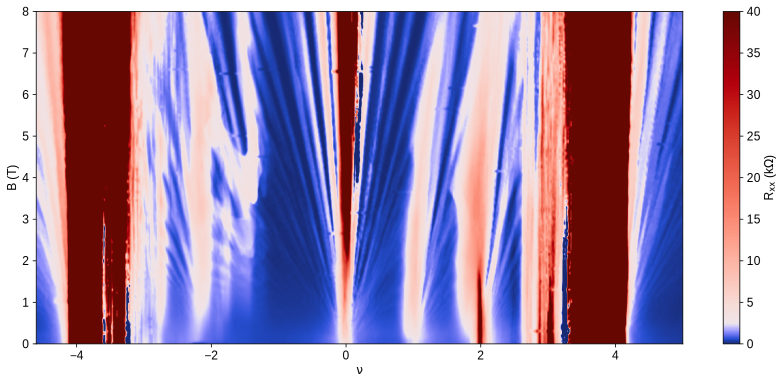

In [22]:
nu4824int = np.linspace(-4.6, 5, 1500)
y4824int = np.linspace(0, 8, 600)
Rxx4824nuint = gaussian_filter(R4824nufunc(nu4824int, y4824int).T, (1.2, 1.2))

plt.figure(figsize=(12, 5.5))
plt.pcolormesh(nu4824int, y4824int, Rxx4824nuint/1000, cmap=cc.cm.diverging_bwr_20_95_c54, norm=DivergingNorm(2.5, 0, 40), rasterized=True)
plt.colorbar(label='R$_{xx}$ (k$\Omega$)')
plt.xlabel('$\\nu$')
plt.ylabel('B (T)')
plt.tight_layout()
# plt.savefig(figfile+'W3_48-24_Fandiagram_baseT.svg', dpi=300, bbox_inches='tight')

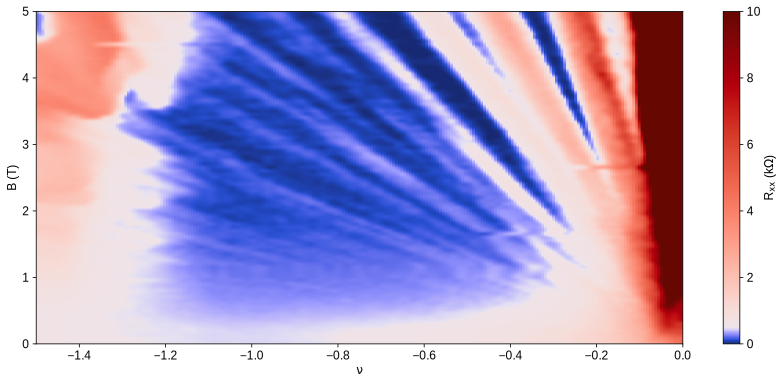

In [34]:
nu4824int = np.linspace(-4.6, 5, 1500)
y4824int = np.linspace(0, 8, 600)
Rxx4824nuint = gaussian_filter(R4824nufunc(nu4824int, y4824int).T, (1.2, 1.2))

plt.figure(figsize=(12, 5.5))
plt.pcolormesh(nu4824int, y4824int, Rxx4824nuint/1000, cmap=cc.cm.diverging_bwr_20_95_c54, norm=DivergingNorm(0.5, 0, 10), rasterized=True)
plt.colorbar(label='R$_{xx}$ (k$\Omega$)')
plt.xlabel('$\\nu$')
plt.ylabel('B (T)')
plt.tight_layout()
plt.axis((-1.5, 0, 0, 5))
# plt.savefig(figfile+'W3_48-24_Fandiagram_baseT_Zoom.svg', dpi=300, bbox_inches='tight')

# W5 device analysis

## W5 Landau Fans

### Electrodes 39-38

This data was analyzed first in the other W3_W5 file that includes PPMS data

In [6]:
dw5fan2 = qc.load_data('data/2020-02-03/#015_W5_865_39-38Rxx_830_38-37Rxx_baseT_2nA_B-Vgsweep_17-50-07')
gw5fan2 = dw5fan2.srframe_volt_p1_set[0, :]
bw5fan2 = dw5fan2.triton_field_set_stable_set[:]
R3938fan2 = npd.Rxxfromdata(dw5fan2, 2e-9, instrument='lockin865')
# R3837fan2 = npd.Rxxfromdata(dw5fan2, 2e-9, instrument='lockin830')

(-7, 7)

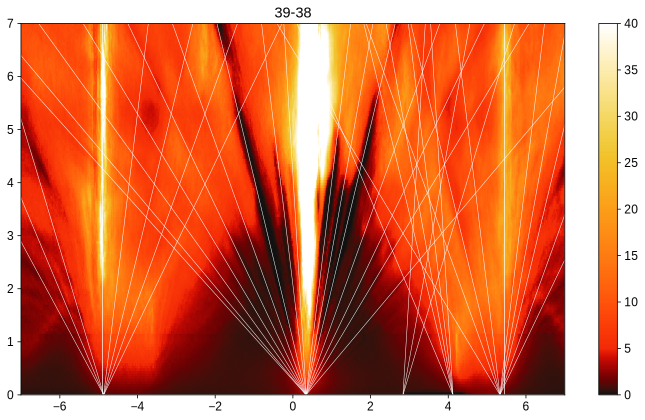

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
p1 = ax.pcolormesh(gw5fan2, bw5fan2, R3938fan2/1000, cmap=cc.cm.linear_kryw_5_100_c64, norm=DivergingNorm(5, 0, 40), rasterized=True)
plt.colorbar(p1, ax=ax)
ax.set_title('39-38')
# p2 = ax[1].pcolormesh(gw5fan2, bw5fan2, R3837fan2/1000, cmap=cc.cm.linear_kryw_5_100_c64, norm=DivergingNorm(8, -2, 50))
# plt.colorbar(p2, ax=ax[1])
# ax[1].set_title('38-37')
plt.tight_layout()

Bl = 7
Bs = 0
V0 = 0.34
sl = 12.2
b = -V0*sl

for i in [-15, -14, -12, -10, -8, -6, -4, -2, -1, 2, 3, 4, 6, 8, 10, 14]:
    x = np.array([(Bs*i - b)/sl, (Bl*i - b)/sl])
    ax.plot(x, (x*sl + b)/i, color='white', lw=0.5)
    
# negative full filling
Vfn = -4.87
bfn = -Vfn*sl

for i in [-9, -7, -5, 2, 4, 6, 8]:
    x = np.array([(Bs*i - bfn)/sl, (Bl*i - bfn)/sl])
    ax.plot(x, (x*sl + bfn)/i, color='white', lw=0.5)

# why is this filling different from negative full filling?
Vfp = 5.33
bfp = -Vfp*sl

for i in [-10, -6, -4, -2, 2, 3, 4, 6, 8]:
    x = np.array([(Bs*i - bfp)/sl, (Bl*i - bfp)/sl])
    ax.plot(x, (x*sl + bfp)/i, color='white', lw=0.5)
    
Vfph = (5.33-V0)/2 + V0
bfph = -Vfph*sl

for i in [1, 3, 5]:  # should this be on the maxima (even) or minima (odd)? 
    x = np.array([(Bs*i - bfph)/sl, (Bl*i - bfph)/sl])
    ax.plot(x, (x*sl + bfph)/i, color='white', lw=0.5)

# maybe... A little greater than 3/4 filling, it seems
Vfp3q = 4.12
bfp3q = -Vfp3q*sl

for i in [-7, -4, -3, -2, -1]:
    x = np.array([(Bs*i - bfp3q)/sl, (Bl*i - bfp3q)/sl])
    ax.plot(x, (x*sl + bfp3q)/i, color='white', lw=0.5)
    
ax.vlines((-4.9, 5.45), 0, 7, color='white', lw = 0.7)

# ax.vlines((V0 - Vgatefull, V0, V0 + Vgatefull), 0, 7, color='black', lw=0.9)
    
ax.set_xlim(-7, 7)
# ax[0].axis((0.3302532331144912, 6.954736397141387, 0.45718093968676854, 6.944018660446515))

In [8]:
0.34+4.9

5.24

In [9]:
5.45-0.34

5.11

In [10]:
V0 = 0.34
sl = 12.2
b = -V0*sl
Vfn = -4.87
C = sl*1.602e-19**2/6.626e-34
dBN = 3*8.85e-12/C
print('effective capacitance: {:.4e}'.format(C))
print('effective hBN thickness: {:.1f} nm'.format(dBN*10**9))
 
# actually, take these values from the peaks at somewhat high field, and they seem more consistent
Vgatefull = (Vfp - Vfn)/2  # take the average of the positive and negative sides, since they vary slightly
print('Full filling voltage difference: {}'.format(Vgatefull))
nfull = Vgatefull*C/1.602e-19/10**4
print(nfull/10**12) #10**12 cm^-2
a = 0.246e-9

theta = np.sqrt(np.sqrt(3)*nfull*10**4*a**2/8)*180/np.pi
print('theta: ', theta)

effective capacitance: 4.7253e-04
effective hBN thickness: 56.2 nm
Full filling voltage difference: 5.1
1.504322970117718
theta:  0.8043843328776603


## W5 T dependence

In [11]:
def SCdomepts(x, R, T, Tidx, xidxstart, xidxstop):
    print('Normalizing temperature', T[Tidx])
    xx = []
    yy = []
    for i in np.arange(xidxstart, xidxstop):
        norm_T = R[:,i]/R[Tidx,i]
        ss = -1
        for j in np.arange(norm_T.shape[0]):
            if norm_T[j]>0.5:
                ss=1
                break
        if ss>0:
            xx.append(x[i])
            yy.append(T[j])

    f = interp1d( xx[::2], yy[::2], kind = 'linear')
    xnew = np.linspace(xx[0],xx[-2], 100)
    return xnew, f(xnew)

In [12]:
dT0 = qc.load_data('data/2020-02-24/#004_W5_basetemp_0p5nA_865_40-39_830_39-38_12-31-17')
dT1 = qc.load_data('data/2020-02-24/#005_W5_basetemp_0p5nA_865_40-39_830_39-38_gateTsweepto1K_0p5nA_16-49-36')
dT2 = qc.load_data('data/2020-02-24/#006_W5_basetemp_865_40-39_830_39-38_gateTsweep1p1to1p4K_0p5nA_22-57-43')
dT3 = qc.load_data('data/2020-02-25/#001_W5_basetemp_865_40-39_830_39-38_gateTsweep1p5to2K_0p5nA_00-19-25')

In [13]:
# electrodes 30-39
temps3938 = np.concatenate(([0.025], dT1.triton_pid_setpoint_set[:], dT2.triton_pid_setpoint_set[:], dT3.triton_pid_setpoint_set[:]))
RxxT3938 = np.vstack((npd.Rxxfromdata(dT0, 0.5e-9, 'lockin830'), npd.Rxxfromdata(dT1, 0.5e-9, 'lockin830'), npd.Rxxfromdata(dT2, 0.5e-9, 'lockin830'), npd.Rxxfromdata(dT3, 0.5e-9, 'lockin830')))
gatesT3938 = dT0.srframe_volt_p1_set[:]
V0 = 0.34 - 0.05
Vgatefull = 5.175000000000001
nugateT3938 = np.interp(gatesT3938, [V0 - 6/4*Vgatefull, V0 + 6/4*Vgatefull], [-6, 6])
RxxT3938_func = RectBivariateSpline(nugateT3938, temps3938, RxxT3938.T, kx=1, ky=1)

In [14]:
temps3938

array([0.025, 0.05 , 0.1  , 0.15 , 0.2  , 0.25 , 0.3  , 0.35 , 0.4  ,
       0.45 , 0.5  , 0.55 , 0.6  , 0.65 , 0.7  , 0.75 , 0.8  , 0.85 ,
       0.9  , 0.95 , 1.   , 1.1  , 1.2  , 1.3  , 1.4  , 1.5  , 1.6  ,
       1.7  , 1.8  , 1.9  , 2.   ])

In [15]:
RxxT3938.shape

(31, 626)

In [16]:
temps3938

array([0.025, 0.05 , 0.1  , 0.15 , 0.2  , 0.25 , 0.3  , 0.35 , 0.4  ,
       0.45 , 0.5  , 0.55 , 0.6  , 0.65 , 0.7  , 0.75 , 0.8  , 0.85 ,
       0.9  , 0.95 , 1.   , 1.1  , 1.2  , 1.3  , 1.4  , 1.5  , 1.6  ,
       1.7  , 1.8  , 1.9  , 2.   ])

In [17]:
nugateT3938[530]

3.3314009661835744

Normalizing temperature 2.0


Text(2.4, 0.12, 'SC')

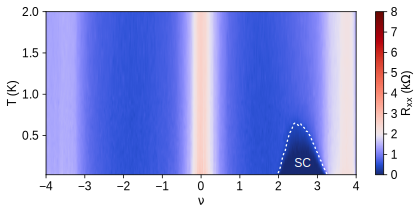

In [18]:
x = np.linspace(-4.86, 4.79, 1501)
y = np.linspace(0.025, 2, 800)
RxxT3938_int = gaussian_filter(RxxT3938_func(x, y).T, (0.8, 0.8))

plt.figure(figsize=(2*3.14961, 3.14961))
plt.pcolormesh(x, y, RxxT3938_int/1000, cmap=cc.cm.diverging_bwr_20_95_c54, norm=DivergingNorm(vmin=0, vcenter=2, vmax=8), rasterized=True)
plt.colorbar(label='R$_{xx}$ (k$\Omega$)')
plt.ylabel('T (K)')
plt.xlabel('$\\nu$')
plt.xlim(-4, 4)
plt.yticks([0.5, 1, 1.5, 2])
plt.xticks(np.arange(-4, 5))
plt.tight_layout()

LW = 1.3
d = (1.7, 1.9)
# electron-side SC pocket############################### using normal temp of 
scx, scy = SCdomepts(nugateT3938, RxxT3938, temps3938, 30, 443, 530)
plt.plot(scx, gaussian_filter(scy, 1.3), linewidth=LW, color='white', linestyle='dashed', dashes=d)
plt.text(2.4, 0.12, 'SC', color='w')
##################################################

# plt.savefig(figfile + 'W5_0p8_3938_lowTdependence.svg', dpi=300, bbox_inches='tight')

In [19]:
nugateT3938[475]

2.4811594202898544

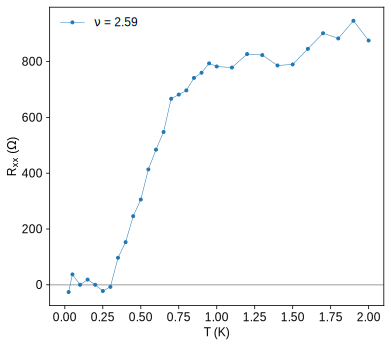

In [20]:
plt.figure(figsize=(6, 5.5))
indx = 482

l1 = plt.plot(temps3938, RxxT3938[:, indx], '.-', lw=0.5, label='$\\nu$ = {:.2f}'.format(nugateT3938[indx]))
xmin, xmax = -0.1, 2.1
plt.legend(frameon=False, loc='upper left')
plt.xlim(xmin, xmax)


plt.xlabel('T (K)')
plt.ylabel('R$_{xx}$ ($\Omega$)')
plt.hlines(0, xmin, xmax, color='gray', alpha=0.5)
# plt.savefig(figfile + 'W5_0p8_SCTlinecut.svg', dpi=300, bbox_inches='tight')

# W5 fraunhofer-like patterns

In [28]:
df3938 = qc.load_data('data/2020-02-08/#012_W5_830_40-39_865_39-38_vbg3p4V_FraunhoferbaseT_0p5nA_22-13-39')  #3.4 Vbg
dvdi3938 = df3938.lockin865_X[:, :]/0.5e-9
curr3938 = df3938.srframe_volt_p5_set[0, :]*10
bf3938 = df3938.triton_field_set_stable_set[:]

In [86]:
V0 = 0.34
Vgatefull = 5.1
Vfraun3938 = 3.4
nufraun3938 = np.interp(Vfraun3938, [V0 - Vgatefull, V0 + Vgatefull], [-4, 4])
print(nufraun3938)

2.4000000000000012


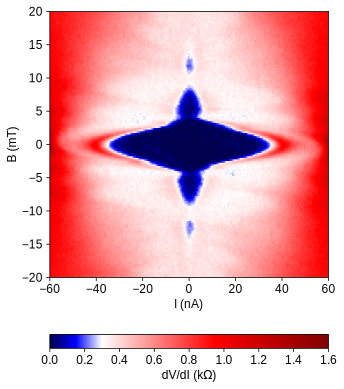

In [85]:
plt.figure(figsize=(5, 7))
plt.pcolormesh(curr3938, bf3938*1000, gaussian_filter(dvdi3938, (0.5, 0.5))/1000, cmap='seismic', norm=DivergingNorm(vmin=0, vmax=1.6, vcenter=0.3), rasterized=True)
plt.colorbar(orientation='horizontal', label='dV/dI (k$\Omega$)')
plt.xlabel('I (nA)')
plt.ylabel('B (mT)')

plt.savefig(figfile+'M05_0p8_3938_fraunhofer.svg', dpi=300, bbox_inches='tight')